## Sentiment Classification using BERT


In [5]:
# Imports
# General utils
import pandas as pd
import numpy as np
import seaborn as sns

# TF
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text

# Model selection and Pipeline utils
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

# Text processing libraries
import re
from nltk.corpus import stopwords
import emoji
import contractions  # from https://github.com/kootenpv/contractions
import string

# Setting to ignore warnings
import warnings
warnings.filterwarnings("ignore")
# Set inline print to 150 chars
pd.set_option('display.max_colwidth', 150)


### Read Data


In [7]:
# Read data and clean a bit
spotify = pd.read_csv("../data/reviews.csv")
data_in = spotify.copy()
data_in = data_in.drop_duplicates(subset="Review")  # Drop dupes in Reviews
data_in.drop(["Time_submitted", "Total_thumbsup",
             "Reply"], axis=1, inplace=True)
data_in["Length"] = data_in["Review"].str.split(" ").str.len()
data_in = data_in[data_in.Length < 150]
data_in.drop(["Length"], axis=1, inplace=True)
data = data_in
data.head(10)


,Review,Rating
0,"Great music service, the audio is high quality and the app is easy to use. Also very quick and friendly support.",5
1,Please ignore previous negative rating. This app is super great. I give it five stars+,5
2,"This pop-up ""Get the best Spotify experience on Android 12"" is too annoying. Please let's get rid of this.",4
3,Really buggy and terrible to use as of recently,1
4,Dear Spotify why do I get songs that I didn't put on my playlist??? And why do we have shuffle play?,1
5,The player controls sometimes disappear for no reason. App restart forgets what I was playing but fixes the issue.,3
6,I love the selection and the lyrics are provided with the song you're listening to!,5
7,"Still extremely slow when changing storage to external sd card.. I'm convinced this is done on purpose, spotify knows of this issue and has done N...",3
8,"It's a great app and the best mp3 music app I have ever used but there is one problem that, why can't we play some songs or find some songs? despi...",5
9,"I'm deleting this app, for the following reasons: This app now has a failing business model. Whether streaming services like it, or not: the consu...",1


### Code Sentiment


In [8]:
# Code sentiment from rating (1 or 2 == bad, 3 == neutral, 4 or 5 == good)
def get_sentiment(rating):
    if rating == 1 or rating == 2 or rating == 3:
        return 0
    # if rating == 3:
    #     return "neutral"
    if rating == 4 or rating == 5:
        return 1


data["Sentiment"] = data["Rating"].apply(get_sentiment)


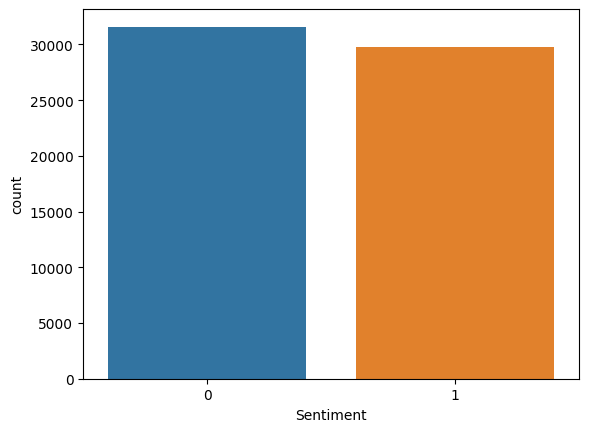

In [14]:
# Plot sentiment distribution
ax = sns.countplot(data=data, x='Sentiment')


We see that we got an almost even split, nice!


### Define Stopwords

Here we grab the NLTK stopwords but want to keep "not"


In [15]:
our_stop_words = set(stopwords.words('english'))
our_stop_words.remove("not")

### Clean data


In [16]:
# Define a function to do some text cleaning
def clean_text(text):
    text = emoji.demojize(text)  # fix emojis
    text = contractions.fix(text)  # fix contractions
    text = re.sub(r'[^\x00-\x7f]', r'', text)  # remove strange fonts
    text = re.sub(r"\d+", "number", text)  # replace numbers with "number"
    text = re.sub(r'[^\w\s]', '', text)  # remove non-alphanumeric chars
    text = text.replace('_', ' ')  # replace underscores with space
    text = text.strip()  # strip extra spaces
    return text


In [17]:
# Test our text cleaner
clean_text("I ❤️ Spotify, even though it is critizised for exploiting artists")


'I red heart Spotify even though it is critizised for exploiting artists'

In [18]:
# Apply to all data
data["Review"] = data["Review"].apply(clean_text)


In [19]:
data.head(10)


,Review,Rating,Sentiment
0,Great music service the audio is high quality and the app is easy to use Also very quick and friendly support,5,1
1,Please ignore previous negative rating This app is super great I give it five stars,5,1
2,This popup Get the best Spotify experience on Android number is too annoying Please let us get rid of this,4,1
3,Really buggy and terrible to use as of recently,1,0
4,Dear Spotify why do I get songs that I did not put on my playlist And why do we have shuffle play,1,0
5,The player controls sometimes disappear for no reason App restart forgets what I was playing but fixes the issue,3,0
6,I love the selection and the lyrics are provided with the song you are listening to,5,1
7,Still extremely slow when changing storage to external sd card I am convinced this is done on purpose spotify knows of this issue and has done NOT...,3,0
8,It is a great app and the best mpnumber music app I have ever used but there is one problem that why cannot we play some songs or find some songs ...,5,1
9,I am deleting this app for the following reasons This app now has a failing business model Whether streaming services like it or not the consumer ...,1,0


### Create features and target and split into training, development and test set


In [20]:
X, y = data["Review"], data["Sentiment"]
print("Shape of X and y: ", X.shape, y.shape)


Shape of X and y:  (61346,) (61346,)


In [21]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)


(49076,) (12270,) (49076,) (12270,)


Roughly foloowing this https://www.section.io/engineering-education/classification-model-using-bert-and-tensorflow/


In [22]:
# Get Bert Preprocessor and Encoder
bert_preprocess = hub.KerasLayer(
    "https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3")
bert_encoder = hub.KerasLayer(
    "https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4")


2022-12-18 13:47:19.837477: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [23]:
# creating an input layer using tf.keras.layers.Input method.
# We will use the preprocessed_text as input for this layer.

text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
preprocessed_text = bert_preprocess(text_input)
outputs = bert_encoder(preprocessed_text)


Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


In [25]:
# Initializing the neural network layers
l = tf.keras.layers.Dropout(0.1, name="dropout")(outputs['pooled_output'])
l = tf.keras.layers.Dense(1, activation='sigmoid', name="output")(l)

In [26]:
# add the input and output layers to construct the final model
model = tf.keras.Model(inputs=[text_input], outputs=[l])

In [27]:
model.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 text (InputLayer)              [(None,)]            0           []                               
                                                                                                  
 keras_layer (KerasLayer)       {'input_word_ids':   0           ['text[0][0]']                   
                                (None, 128),                                                      
                                 'input_type_ids':                                                
                                (None, 128),                                                      
                                 'input_mask': (Non                                               
                                e, 128)}                                                      

In [28]:
METRICS = [
    tf.keras.metrics.BinaryAccuracy(name='accuracy'),
    tf.keras.metrics.Precision(name='precision'),
    tf.keras.metrics.Recall(name='recall')
]

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=METRICS)


In [29]:
print("GUP: ", tf.config.list_physical_devices('GPU'))
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))


GUP:  []
Num GPUs Available:  0


With CPU, it's about 1hr 20 mins per epoch,
with GPU it's about 15 mins


In [30]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy',
                                                  mode='auto',
                                                  patience=3,
                                                  restore_best_weights=True)


In [33]:
epochs = 20
hist = model.fit(X_train, y_train, batch_size=128, epochs=epochs,
                 validation_data=(X_test, y_test),
                 callbacks=[early_stopping])


In [56]:
y_pred = model.predict(X_test)
y_pred = y_pred.flatten()

384/384 [==============================] - 181s 470ms/step


In [58]:
y_pred = np.where(y_pred > 0.5, "positive", "negative")
y_pred

array(['positive', 'negative', 'positive', ..., 'negative', 'negative',
       'negative'], dtype='<U8')

In [57]:
# Evaluate the model on the test data using `evaluate`
print("Evaluate on test data")
results = model.evaluate(X_test, y_test, batch_size=128)
print("test loss, test acc:", results)


Evaluate on test data
96/96 [==============================] - 295s 3s/step - loss: 0.3801 - accuracy: 0.8420 - precision: 0.8747 - recall: 0.7870
test loss, test acc: [0.38014230132102966, 0.841972291469574, 0.8746965527534485, 0.7869623899459839]


In [101]:
# Save the entire model as a SavedModel.
!mkdir -p saved_model
model.save('../models/bert_model')

INFO:tensorflow:Assets written to: ../models/bert_model\assets


INFO:tensorflow:Assets written to: ../models/bert_model\assets


In [96]:
def make_prediction(classifier, text):
    text = clean_text(text)
    prediction = classifier.predict([text])[0][0]
    print("This review is:", np.where(prediction > 0.5, "positive", "negative"))


In [100]:
review = "I ❤️ Spotify, even though it sucks"

make_prediction(model, review)


1/1 [==============================] - 0s 104ms/step
This review is: positive


In [98]:
review = "I don't like Spotify, can not recommend, poor recommendations"

make_prediction(model, review)

1/1 [==============================] - 0s 91ms/step
This review is: negative
